# DRF Parameter Validation (Part 2)

In this notebook you are going to evaluate a DRF-based driving behaviour model to control the SDV with a protocol named *close-loop* evaluation in a series of assigned Lyft scenes.


## What is close-loop and open-loop evaluation?
In close-loop evaluation, the SDV is completely controlled by our customized model throughout a scene. In each scene, the SDV should make ~250 predictions regarding its future position.

Whereas in open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth. In each frame, we compare the predictions of our model against the annotated ground truth.

<!-- **Regardless of the metric used, this evaluation protocol doesn't modify the future locations according to our predictions.**

![open-loop](../../docs/images/planning/open-loop.svg) -->


## What can we use close-loop evaluation for?
Closed-loop is crucial to asses a model's capabilities before deploying it in the real world. Ideally, we would test the model on the road in the real world. However, this is clearly very expensive and scales poorly. Forward-simulation is an attempt to evaluate the system in a setting which is as close as possible to a real road test on the same route.

Differently from open-loop, the model is in full control of the SDV and predictions are used to compute the future location of the SDV.


## Is close-loop evaluation enough?
Closed-loop evaluation is an important step forward towards evaluating how our policy would perform on the road. However, it still has some limitations.

The critical one is the non-reactivity of other traffic participants. In fact, while the SDV is now controlled by our policy, other actors are still being replayed from the original log. In this setting, a chasing car will not slow down if our policy choses a different speed profile for the SDV, resulting in a rear collision that wouldn't obviously occur in the real world.

For this reason, closed-loop evaluation is only accurate for the first few seconds of forward simulation. This can be mitigated when enough data exists for the task.

This DRF-based driver behaviour model is intended to serve as the reactive traffic agents in future simulations. This notebook demonstrate how we validate its capability with the Lyft prediction dataset.

## Imports & packages

In [1]:
## from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
#from l5kit.dataset import EgoDataset
#from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, transform_point
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

from Param_Estimation.map.map_builder import MapBuilder
from Param_Estimation.driver.DRFModel import DRFModel
from Param_Estimation.map.rasterizer_builder import build_rasterizer
from Param_Estimation.dataset.ego import EgoDataset

import os

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "."
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the evaluation data
**we don't change our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data.

In [3]:
# ===== INIT DATASET
eval_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Driver controller
**This controller is a simple controller example implementing risk-threshold**.

Input: current perceived risk...

Output: velocity

In [4]:
# driver controller 2: Lane keeping (car following)
from typing import Dict, List, Optional, Tuple, Union
from scipy import optimize
from Param_Estimation.driver.DRFModel import DRFModel

k_h = 0.02 # gain of default heading P-controller
k_v = 0.025 # gain of vehicle's speed-up/down, could be different for normal or sport driving
k_vc = 1.5 * 1e-4 # gain of vehicle's speed-down contributed by the perceived risk (cost)
dt = 0.1 # [s] step time
dvMax = 4 * dt # [m/s^2] Vehicle max decel and acceleration
dvstepMax = 20 * dt # For fminbnd search
dsMax = np.pi / 180 * 1 * dt # [rad/dt] Note: Here assume steer limit is 10 degree/s, be careful with unit!
dstepMax = np.pi / 180 * 50 * dt # [rad/dt] Note: For fminbound search
egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823, safe_distance=10, cost_threshold=7000)

def driverController2(curr_road_heading: float, ego_curr_heading_world: float, curr_risk: float, ego: DRFModel, v_des: float, Ct: float) -> Tuple[float, float]:
    risk_threshold = Ct
    desired_vel = v_des
    curr_vel = ego.v
    ego_heading = ego.phiv # assume ego's ground truth heading is the current road heading
    curr_steering = ego.delta
    next_steering =  curr_steering #+ k_h * (curr_road_heading - ego_curr_heading_world)
    if (curr_risk <= risk_threshold and curr_vel <= desired_vel):
        # condition 1
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        #print("condition1 vel = ", next_vel)
        return next_steering, next_vel
    elif (curr_risk > risk_threshold and curr_vel <= desired_vel):
        # check if changing velocity alone can reduce the cost below the threshold
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        if (minCost >= risk_threshold):
            # condition 2a
            # velocity update
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel)) 
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            if (next_vel < 0):
                next_vel = 0
            #print("condition2a vel = ", next_vel)
            return next_steering, next_vel
            
#         model slows down
#         proportional to Cop − Ck (and not Cop − Ct) since the steering applied = wop is
#         expected to reduce Ck to Cop. This is done so that we do not slow down more than
#         what is required. Hence, w_k+1 = wop 
        elif (minCost < risk_threshold):
            # condition 2b
            # velocity update
            opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocityCt, x1=curr_vel - dvstepMax, 
                                                               x2=curr_vel + dvstepMax, full_output=True)
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel))
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            if (next_vel < 0):
                next_vel = 0
            #print("condition2b vel = ", next_vel)
            return next_steering, next_vel

        else:
            print("Error in stage: condition 2")
        
        # /* In this case the model slows down, while being
        # ** steered by the heading controller since the risk is lower than the threshold and
        # ** speed is higher than what is desired.
        # */
    elif (curr_risk <= risk_threshold and curr_vel > desired_vel):
        # condition 3
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        #print("condition3 vel = ", next_vel)
        return next_steering, next_vel
        
        # /* In this case both the speed and risk are over
        # ** the desired limits and hence the model slows down while steering with δop that
        # ** minimises Ck
        # */
    elif (curr_risk > risk_threshold and curr_vel > desired_vel):
        # condition 4
        # velocity update
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        dv = np.fmin(dvMax, np.abs(opt_v - curr_vel) + k_v * (desired_vel - curr_vel))
       
        next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
        #print("condition4 vel = ", next_vel)
        return next_steering, next_vel

    else: 
        print("Error at driver controller: no situations match!")
    print("Next steering = ", next_steering)
    print("Next Velocity = ", next_vel)

Some metrics evaluating model performance

In [5]:
from scipy import optimize, spatial
# Compute the error in position between gt and pred
def computePosError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    error_arr = np.array(gts) - np.array(preds)
    error_x = error_arr[:, 0]
    error_y = error_arr[:, 1]
    error_pos = np.sqrt(error_x**2 + error_y**2)
    mean_error_pos = np.mean(error_pos)
    return error_pos, mean_error_pos

def computeYawError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    yaw_preds = np.ravel(np.array(preds))
    yaw_gts = np.ravel(np.array(gts))
    error_yaws = yaw_gts - yaw_preds
    mean_error_yaw = np.mean(np.abs(error_yaws))
    return error_yaws, mean_error_yaw

def dist2Reference(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    
    # This solution is optimal when xy2 is very large
    tree = spatial.cKDTree(gts)
    mindist, minid = tree.query(preds)
    mean_error_lat = np.mean(mindist)
    return mindist, mean_error_lat

Helper functions filtering out noises in the Lyft dataset

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid') # This will output dimensions N-M+1
    return y_smooth

def filterPosition(ego_pos: np.ndarray, k: float, b: float):
    m = ego_pos[0]
    n = ego_pos[1]
    ego_pos[0] = (n + m / k - b) / (k + 1 / k)
    ego_pos[1] = k * ego_pos[0] + b
    return ego_pos

This cell below is used to select lane-keeping and braking scenes from the dataset.

Feel free to skip the following 2 cells and you can start from the validation cell directly.

In [179]:
from scipy.signal import find_peaks
# Select lane-keeping scenes
valid_scene_indices = []
vels = []
yaws = []
dataset = eval_dataset

for scene_idx in [1, 11, 17, 31, 60, 85, 91, 99, 104, 106,
                 159, 194, 196, 240, 251, 353, 474, 487, 544, 605,
                 619, 647, 754, 799, 830, 832, 835, 894, 919, 946,
                 951, 991, 1072, 1103, 1108, 1118, 1125, 1152, 1200, 1207,
                 1217, 1250, 1262, 1280, 1294, 1332, 1333, 1444, 1484, 1587]:#np.arange(3500, 3600): 
    indexes = dataset.get_scene_indices(scene_idx)#113
    for idx in indexes[:-1]: # throughout each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        yaws.append(curr_road_heading)
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        vels.append(gt_vel)
    
    vels = np.array(vels)
    yaws = np.array(yaws)
    accs = np.diff(vels) / 0.1 # acc = dv / dt
    # filter out consecutive deceleration scenes
    smooth_accs = smooth(accs, 10)
    decs = smooth_accs[smooth_accs < 0]
    min_dec = np.mean(smooth_accs[smooth_accs.argsort()[:10]])
    # FILTER OUT large deceleration after peak velocity
    smooth_vels = smooth(vels, 10)
    max_vel = np.max(smooth_vels)#np.mean(smooth_vels[smooth_vels.argsort()[:-5]])
    max_vel_idx = np.argmax(smooth_vels)
    min_vel = np.mean(smooth_vels[smooth_vels.argsort()[:5]])
    min_vel_idx = np.argmin(smooth_vels)
    
#     # decerleration profile
#     peaks, _ = find_peaks(-smooth_vels, height=-max_vel+0.4)
#     #print(smooth_vels[peaks])
#     lags = smooth_vels[max_vel_idx:]
#     lags = lags[lags < max_vel - 0.4]
#     #print(lags.size)
    
    # This filter protocol selects lane-keeping and car-following scenes
#     if (min_vel < 3.0 and np.mean(vels) > 10 and np.max(yaws) - np.min(yaws) < 15 / 180 * np.pi):# and peaks.size == 0 and lags.size == 0):
#         valid_scene_indices.append(scene_idx)

    # This filter selects braking scenes due to stopping leading vehicle
    if (np.max(yaws) - np.min(yaws) < 5 / 180 * np.pi and np.min(smooth_accs) < -1.5):
        min_acc_idx = indexes[np.argmin(smooth_accs)]
        min_acc_frame = dataset[min_acc_idx]
        obj_map = min_acc_frame["image"]

        front = obj_map[50][50:80]
        front = front[front >= 2500]
        if (front.size >= 1):
            peaks, _ = find_peaks(smooth_vels, distance=20)
            #print(peaks.size)
            if (peaks.size == 1 or peaks.size == 0):
                valid_scene_indices.append(scene_idx)

    vels = []
    yaws = []
    #break

In [180]:
# see valid lane keeping scenes
valid_scene_indices = np.array(valid_scene_indices)
print(valid_scene_indices)
# for scene_idx in valid_scene_indices:
#     print(scene_idx)
# indices = [0, 1] 
# print(indices)

# Valid scenes (car-following/lane-keeping): (## means too noisy)
#[6, 19, 21, 35, 37, 64, 71]
#[114, 158, 167, 199]
#[209, 256, 290, 300, 331, 333, 335]
#[688, 718, 818, 868, 920, 922, 943, 998]
#[1031, 1059, 1112, 1235, 1319, 1339, 1351, 1381]
#[#1400# 1409 #1412# 1427, 1462, 1463,]
#[1511, 1553, 1554, 1616, 1644, 1678, 1695]
#[1745, 1757, 1779, 1828, 1849, 1859, 1878, #1896#, 1987]

# How about braking to avoid collision?
# [1]

[  31   60  104  159  194  196  240  251  353  474  487  544  605  619
  647  754  799  832  835  894  919  946  951 1072 1103 1108 1118 1125
 1152 1200 1207 1217 1250 1262 1280 1294 1332 1444 1484 1587]


## Batch validation

In [21]:
# ===== Parameter Estimation (closed-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gts to preds
"""
from matplotlib.patches import Rectangle

position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []
vel_preds = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []
vel_gts = []
p_risks = []

# Set safe distance and cost threshold
SD = 12
CT = 9000
# Set safe distance and cost threshold
# speed limit of Palo Alto
speed_limit = [13.5, 11.1, 8.7]

#scene_indices = [1400, 1412, 1462, 1463, 17, 1828, 1849, 1859, 1878, 1987] # 10 scenes for parameter identification!
#scene_indices = [6, 19, 21, 35, 37, 64, 71, 114, 158, 167, 199, 209, 256, 290, 300, 331, 333, 335, 1, 688, 718, 818, 868, 920, 922, 943, 998, 1031, 1059, 1112, 1235, 1319, 1339, 1351, 1381, 1409, 1427, 1511, 1553, 1554, 1616, 1644, 1678, 1695, 1745, 1757, 1779]
# scene_indices = [1400, 1412, 1462, 1463, 9973, 1828, 1849, 1859, 1878, 1987,
#                  6, 19, 21, 35, 37, 64, 71, 114, 158, 167,
#                  199, 209, 256, 290, 300, 331, 333, 335, 9972, 688,
#                  16, 818, 868, 920, 922, 943, 998, 1031, 1059, 1112,
#                  1235, 1319, 1339, 1351, 1381, 1409, 1427, 1511, 1553, 1554]
                  
scene_sizes = []
# scene_indices = [1616, 1644, 1678, 1695, 1745, 1757, 1779, 2010, 2065, 2146, 
#                  2171, 2231, 2271, 2306, 2307, 2349, 2372, 2423, 2508, 2517,
#                  2518, 2528, 2567, 2595, 2609, 2640, 2672, 2686, 2688, 2713,
#                  2750, 2883, 2908, 2944, 2946, 2988, 2989, 3048, 3049, 3093,
#                  3048, 3049, 3093, 3115, 3129, 3160, 3161, 3162, 3177, 3194]

# scene_indices = [3215, 3277, 3312, 3332, 3417, 3418, 3419, 3507, 3508, 3509,
#                  3510, 3536, 3553, 3581, 3582, 3599, 3600, 3606, 3628, 3629,
#                  3630, 3642, 3643, 3652, 3654, 3680, 3681, 3697, 3699, 3712,
#                  3736, 3737, 3738, 3756, 3757, 3758, 3772, 3787, 3808, 3810,
#                  3836, 3856, 3895, 3896, 3914, 3915, 3957, 3973, 3992, 3994]

# scene_indices = [4014, 4018, 4035, 4036, 4037, 4038, 4039, 4051, 4069, 4087,
#                  4089, 4103, 4126, 4128, 4150, 4173, 4174, 4175, 4185, 4187,
#                  4215, 4230, 4232, 4245, 4262, 4263, 4264, 4307, 4308, 4309,
#                  4320, 4337, 4361, 4380, 4382, 4383, 4536, 4547, 4569, 4570,
#                  4580, 4595, 4596, 4613, 4614, 4628, 4642, 4643, 4658, 4659]

# scene_indices = [4660, 4690, 4708, 4738, 4739, 4740, 4761, 4762, 4780, 4787,
#                  4810, 4811, 4812, 4872, 4882, 4899, 4900, 4916, 4917, 4918,
#                  4929, 4952, 4953, 4972, 4973, 4974, 4987, 5041, 5042, 5043,
#                  5061, 5062, 5077, 5079, 5103, 5104, 5105, 5124, 5125, 5126,
#                  5138, 5154, 5155, 5156, 5176, 5177, 5252, 5270, 5271, 5272]

# scene_indices = [5327, 5350, 5351, 5403, 5404, 5405, 5429, 5440, 5441, 5442,
#                  5462, 5494, 5567, 5568, 5579, 5597, 5613, 5615, 5632, 5663,
#                  5664, 5665, 5698, 5699, 5732, 5765, 5766, 5778, 5821, 5822,
#                  5823, 5828, 5853, 5864, 5865, 5866, 5884, 5897, 5907, 5921,
#                  5942, 5955, 5997, 6007, 6033, 6055, 6056, 6070, 6147, 6232]

# scene_indices = [6251, 6255, 6284, 6305, 6307, 6337, 6452, 6454, 6465, 6505,
#                  6507, 6560, 6639, 6660, 6675, 6676, 6683, 6684, 6726, 6727,
#                  6783, 6822, 6946, 7029, 7113, 7242, 7320, 7339, 7341, 7461,
#                  7482, 7492, 7523, 7620, 7621, 7627, 7663, 7722, 7735, 7815,
#                  7816, 7860, 7906, 7907, 7908, 7909, 7941, 7960, 7963, 7996]

## unused LK/CF scenes
# scene_indices = [7998, 8045, 8062, 8070, 8088, 8107, 8139, 8156, 8191, 8192,
#                  8211, 8240, 8241, 8262, 8263, 8264, 8289, 8308, 8309, 8310,
#                  8366, 8455, 8473, 8474, 8507, 8522, 8523, 8524, 8573, 8574,
#                  8575, 8669, 8670, 8683, 8709, 8710, 8711, 8717, 8739, 8750,
#                  8751, 8771, 8787, 8788, 8789, 8813, 8814, 8826, 8827, 8867]

# scene_indices = [8868, 8869, 8872, 8907, 8929, 8930, 8989, 8990, 9003, 9047,
#                  9082, 9153, 9154, 9155, 9164, 9187, 9203, 9204, 9205, 9213,
#                  9268, 9269, 9346, 9373, 9419, 9492, 9493, 9535, 9553, 9554,
#                  9586, 9598, 9622, 9686, 9687, 9702, 9703, 9704, 9750, 9751,
#                  9778, 9779, 9804, 9805, 9855, 9908, 9909, 9922, 9924, 9931]

# scene_indices = [9933, 9954, 9971, 718,]
## unused LK/CF scenes

# scene_indices = [1, 11, 17, 31, 60, 85, 91, 99, 104, 106,
#                  159, 194, 196, 240, 251, 353, 474, 487, 544, 605,
#                  619, 647, 754, 799, 830, 832, 835, 894, 919, 946,
#                  951, 991, 1072, 1103, 1108, 1118, 1125, 1152, 1200, 1207,
#                  1217, 1250, 1262, 1280, 1294, 1332, 1333, 1444, 1484, 1587]

scene_indices = [1629, 1641, 1676, 1681, 1688, 1724, 1792, 1816, 1866, 1891,
                 1912, 1991, 2040, 2060, 2073, 2078, 2100, 2173, 2294, 2351,
                 2398, 2403, 2446, 2470, 2549, 2617, 2664, 2692, 2730, 2761,
                 2792, 2816, 2840, 2849, 2850, 2853, 2859, 2877, 2912, 2995,
                 3012, 3043, 3107, 3217, 3227, 3242, 3298, 3300, 3446, 3531]

# scene_indices = [1]
# Initialisation 
# step 1: get ego car's initial heading and postion of each subscene
# Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
for scene_idx in scene_indices:
    indexes = dataset.get_scene_indices(scene_idx) # set scene index here!
    scene_sizes.append(indexes.size - 1) # record the number of frames in each scene

    # Initialisation
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    first_frame_idx = indexes[0]
    first_frame = dataset[first_frame_idx]

    ego = DRFModel(p=0.002, t_la=3.5, c=0.4, m=0.001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
    egoDRF = DRFModel(p=0.002, t_la=3.5, c=0.4, m=0.001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)

    # world frame initial pose of ego vehicle
    x0 = first_frame["centroid"][0]
    y0 = first_frame["centroid"][1]
    phiv0 = first_frame["yaw"] 

    first_heading = first_frame["yaw"] 
    ego_curr_heading_world = first_frame["yaw"] 
    ego_position_world = first_frame["centroid"]

    # initialisation step 2:
    # compute gt velocity, record ground truth velocity, yaw and position

    # TODO: Assume at each scene, the vehicle's ground thuth heading is the road heading
    # Need to implement a method to compute the road heading for the ego vehicle to follow

    temp_position_gts_world = [] # for direction calibration to mitigate lateral deviation, restart for each scene
    temp_vel_gts = [] # for desired velocity computation for each scene
    for idx in indexes[:-1]: # all frames of each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        # record ground truth position
        temp_position_gts_world.append(curr_frame["centroid"])
        position_gts_world.append(curr_frame["centroid"])

        # compute/record ground truth velocity
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        temp_vel_gts.append(gt_vel)
        vel_gts.append(gt_vel)

        # record ground truth yaw
        yaw_gts.append(curr_frame["target_yaws"][0])
        yaw_gts_world.append(curr_frame["yaw"])
    
    max_vel = np.max(smooth(np.array(temp_vel_gts), 10))
    diff_limit = np.abs(speed_limit - max_vel)
    f_vel = speed_limit[np.argmin(diff_limit)] # desired speed is the speed limit
    egoDRF.v = smooth(np.array(temp_vel_gts), 3)[0] # starting with initial speed
    ego.v = egoDRF.v
    # egoDRF in raster frame
    ego.x = 50
    ego.y = 50
    ego.phiv = 0
    
    # Mitigate lateral deviation from center line due to untrackable lane headings
    pworld = np.array(temp_position_gts_world)
    px = pworld[:, 0]
    py = pworld[:, 1]
    coef = np.polyfit(px, py, 1)
    k1 = coef[0]
    b1 = coef[1]

    # Mitigate lateral deviation from center line due to untrackable lane headings

    # Prediction starts here!
    for idx in indexes[:-1]: # all frames of each scene
        # record position prediction
        position_preds_world.append(ego_position_world)

        # record yaw and velocity prediction
        yaw_preds.append(egoDRF.phiv)
        yaw_preds_world.append(ego_curr_heading_world)
        vel_preds.append(egoDRF.v)
        
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        # ego_curr_heading_world += egoDRF.phiv
        ego_curr_heading_world = curr_road_heading

        obj_map = dataset.get_image_from_position(frame_idx=idx, position=ego_position_world, yaw=ego_curr_heading_world)
    #         print(ego_curr_heading_world)
    #         # for debugging
    #         p_im = egoDRF.obj_map
    #         p_im = plt.imshow(p_im, animated=True)
    #         p_ims.append([p_im])
    #         # for debugging
#         plt.imshow(obj_map)
#         plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#         plt.show() 

        # leading distance extraction
        front = obj_map[49:51, 50:]
        front_obs = np.argmax(front == 2500) # find the first element that's an obstacle
        if (front_obs != 0 and front_obs != 50): # if obstacle exists
            front_obs_tmp = np.argmax(front == 2500, axis=1) # find the first element in each row that's an obstacle
            front_obs_tmp = front_obs_tmp[front_obs_tmp > 0]
            front_obs = np.min(front_obs_tmp)

        # if leading distance <= 1.5SD, use braking parameter
        if (front_obs > 0 and front_obs <= 1.5 * SD): 
            #print("brake")
            vel_prev = egoDRF.v
            egoDRF = DRFModel(p=0.6, t_la=3.5, c=0.4, m=0.0001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
            egoDRF.v = vel_prev
            egoDRF.obj_map = obj_map
            ego.v = egoDRF.v
            ego.obj_map = obj_map
        # else use car folowing parameter
        else:
            #print("follow")
            vel_prev = egoDRF.v
            egoDRF = DRFModel(p=0.002, t_la=3.5, c=0.4, m=0.0001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
            egoDRF.v = vel_prev
            egoDRF.obj_map = obj_map
            ego.v = egoDRF.v
            ego.obj_map = obj_map
        # leading distance extraction
        
        egoDRF.x = 50 # or first_frame["centroid"][:2]? (world frame)
        egoDRF.y = 50
        egoDRF.phiv = 0.
        
        p_risk = egoDRF.overallProcess()
        p_risks.append(ego.overallProcess())
        
    #         # for debugging
    #         sub_map = egoDRF.zOfGaussian
    #         p_im = sub_map
    #         p_im = plt.imshow(p_im, animated=True)
    #         p_ims.append([p_im])
    #         # for debugging
    #         plt.imshow(egoDRF.zOfGaussian)
    #         plt.show() 
        
        egoDRF.delta, egoDRF.v = driverController2(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF, f_vel, CT)
        egoDRF.carKinematics()

        # Record groundtruth path
        position_gts.append(curr_frame["target_positions"][0])
        
        # Record actual path
        # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
        pose_in_world = np.array(
            [
                [np.cos(ego_curr_heading_world), -np.sin(ego_curr_heading_world), ego_position_world[0]],
                [np.sin(ego_curr_heading_world), np.cos(ego_curr_heading_world), ego_position_world[1]],
                [0, 0, 1],
            ]
        )
        
        raster_from_world = dataset.rasterizer.render_context.raster_from_local @ np.linalg.inv(pose_in_world)
        ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(raster_from_world))
        ego_position_world = filterPosition(ego_position_world, k1, b1)


condition3 vel =  9.368977226550967
condition3 vel =  9.352252795887193
condition3 vel =  9.335946475990013
condition3 vel =  9.320047814090263
condition3 vel =  9.304546618738005
condition3 vel =  9.289432953269555
condition3 vel =  9.274697129437817
condition3 vel =  9.26032970120187
condition3 vel =  9.246321458671824
condition3 vel =  9.232663422205029
condition3 vel =  9.219346836649903
condition3 vel =  9.206363165733656
condition3 vel =  9.193704086590314
condition3 vel =  9.181361484425556
condition3 vel =  9.169327447314917
condition3 vel =  9.157594261132044
condition3 vel =  9.146154404603742
condition3 vel =  9.135000544488648
condition3 vel =  9.124125530876432
condition3 vel =  9.113522392604521
condition3 vel =  9.103184332789407
condition3 vel =  9.093104724469672
condition3 vel =  9.08327710635793
condition3 vel =  9.073695178698982
condition3 vel =  9.064352799231507
condition3 vel =  9.055243979250719
condition3 vel =  9.04636287976945
condition3 vel =  9.03770380777

condition2b vel =  2.3426415330560646
condition1 vel =  2.501575494729663
condition1 vel =  2.656536107361421
condition1 vel =  2.8076227046773856
condition1 vel =  2.954932137060451
condition1 vel =  3.0985588336339394
condition1 vel =  3.2385948627930907
condition1 vel =  3.3751299912232633
condition1 vel =  3.508251741442682
condition1 vel =  3.638045447906615
condition1 vel =  3.7645943117089495
condition3 vel =  9.133622740159344
condition3 vel =  9.122782171655361
condition3 vel =  9.112212617363976
condition3 vel =  9.101907301929877
condition3 vel =  9.09185961938163
condition3 vel =  9.082063128897088
condition3 vel =  9.072511550674662
condition3 vel =  9.063198761907795
condition3 vel =  9.0541187928601
condition3 vel =  9.045265823038598
condition3 vel =  9.036634177462632
condition3 vel =  9.028218323026067
condition3 vel =  9.020012864950415
condition3 vel =  9.012012543326655
condition3 vel =  9.004212229743489
condition3 vel =  8.996606923999902
condition3 vel =  8.9891

condition2a vel =  6.595083688009866
condition2a vel =  6.195083688009865
condition2a vel =  5.795083688009865
condition2a vel =  5.395083688009865
condition2a vel =  4.995083688009864
condition2a vel =  4.595083688009864
condition2a vel =  4.195083688009864
condition2a vel =  3.7950836880098637
condition2a vel =  3.395083688009864
condition2a vel =  2.995083688009864
condition2a vel =  2.595083688009864
condition2a vel =  2.195083688009864
condition2a vel =  1.7950836880098642
condition2b vel =  1.3950836880098643
condition2b vel =  0.9950836880098642
condition2b vel =  0.6368036478089268
condition1 vel =  0.8383835566137037
condition1 vel =  1.034923967698361
condition2b vel =  0.914150736248516
condition2b vel =  0.6284548321981963
condition2b vel =  0.6284558693609442
condition2b vel =  0.6284558693647719
condition2b vel =  0.6284558693647719
condition2b vel =  0.6284558693647719
condition2b vel =  0.6284543171296352
condition2b vel =  0.6284543171239059
condition2b vel =  0.628454

condition2b vel =  1.7711690863423943
condition2b vel =  1.7711686130043651
condition1 vel =  1.944389397679256
condition1 vel =  2.1132796627372743
condition2b vel =  2.0568657938285972
condition1 vel =  2.222944148982882
condition1 vel =  2.38487054525831
condition1 vel =  2.542748781626852
condition1 vel =  2.696680062086181
condition1 vel =  2.8467630605340264
condition1 vel =  2.9930939840206756
condition1 vel =  3.135766634420159
condition1 vel =  3.274872468559655
condition1 vel =  3.4105006568456635
condition1 vel =  3.5427381404245217
condition1 vel =  3.6716696869139085
condition1 vel =  3.797377944741061
condition3 vel =  9.536135331752751
condition3 vel =  9.515231948458933
condition3 vel =  9.49485114974746
condition3 vel =  9.474979871003773
condition3 vel =  9.455605374228679
condition3 vel =  9.436715239872962
condition3 vel =  9.418297358876139
condition3 vel =  9.400339924904236
condition3 vel =  9.38283142678163
condition3 vel =  9.36576064111209
condition3 vel =  9.

condition2b vel =  1.48549770347979
condition1 vel =  1.6658602608927953
condition1 vel =  1.8417137543704754
condition1 vel =  2.0131709105112137
condition1 vel =  2.1803416377484335
condition1 vel =  2.343333096804723
condition2b vel =  2.3425770384240687
condition2b vel =  2.342595817853968
condition2b vel =  2.3425958179233577
condition2b vel =  2.342589881980941
condition1 vel =  2.5015251349314176
condition1 vel =  2.656487006558132
condition1 vel =  2.8075748313941786
condition1 vel =  2.954885460609324
condition1 vel =  3.0985133240940907
condition1 vel =  3.2385504909917384
condition1 vel =  3.375086728716945
condition1 vel =  3.5082095604990213
condition1 vel =  3.638004321486546
condition1 vel =  3.764554213449382
condition1 vel =  3.8879403581131475
condition1 vel =  4.008241849160319
condition1 vel =  4.125535802931311
condition1 vel =  4.239897407858028
condition1 vel =  4.351399972661578
condition1 vel =  4.460114973345038
condition1 vel =  4.566112099011412
condition1 v

condition2a vel =  12.259072561192154
condition2a vel =  11.859072561192153
condition2a vel =  11.459072561192153
condition2a vel =  11.059072561192153
condition2a vel =  10.659072561192152
condition2a vel =  10.259072561192152
condition2a vel =  9.859072561192152
condition2a vel =  9.459072561192151
condition2a vel =  9.059072561192151
condition2a vel =  8.65907256119215
condition2a vel =  8.25907256119215
condition2a vel =  7.85907256119215
condition2a vel =  7.45907256119215
condition2a vel =  7.059072561192149
condition2a vel =  6.659072561192149
condition2a vel =  6.2590725611921485
condition2a vel =  5.859072561192148
condition2a vel =  5.459072561192148
condition2a vel =  5.059072561192147
condition2a vel =  4.659072561192147
condition2a vel =  4.259072561192147
condition2a vel =  3.859072561192147
condition2a vel =  3.459072561192147
condition2a vel =  3.059072561192147
condition2b vel =  2.692547384307548
condition1 vel =  2.962733699699859
condition2b vel =  3.213043544311642

condition2b vel =  0.07651811605260508
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2b vel 

condition2b vel =  0.2580750041455297
condition2b vel =  0.2580750041455297
condition2b vel =  0.2580750041455297
condition2b vel =  0.2580750041455297
condition2b vel =  0.2580750041455297
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.25807470352755724
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.19427803634619067
condition2b vel =  0.19427796055598176
condition2b vel =  0.19427796055571606
condition2b vel =  0.19427796055571617
condition2b vel =  0.19427796055571617
condition2b vel =  0.19427796055571617
condition2b vel =  0.15943488793436142
condition2b vel =  0.19427762697170464
condition2b vel =  0.1594348879327749
condition2b vel =  0.15943469407766134
condition1 vel =  0.3729488267257198
condition2b vel =  0.40508285021049223
condition2b vel =  0.3765

condition1 vel =  7.894561061996815
condition1 vel =  7.914697035446895
condition1 vel =  7.934329609560722
condition1 vel =  7.953471369321703
condition1 vel =  7.972134585088661
condition1 vel =  7.990331220461444
condition1 vel =  8.008072939949908
condition1 vel =  8.025371116451161
condition1 vel =  8.042236838539882
condition1 vel =  8.058680917576385
condition1 vel =  8.074713894636975
condition1 vel =  8.090346047271051
condition1 vel =  8.105587396089275
condition1 vel =  8.120447711187044
condition1 vel =  8.134936518407368
condition1 vel =  8.149063105447183
condition1 vel =  8.162836527811004
condition1 vel =  8.17626561461573
condition1 vel =  8.189358974250336
condition1 vel =  8.202124999894078
condition1 vel =  8.214571874896727
condition1 vel =  8.226707578024309
condition1 vel =  8.238539888573701
condition1 vel =  8.250076391359359
condition1 vel =  8.261324481575375
condition1 vel =  8.27229136953599
condition1 vel =  8.28298408529759
condition1 vel =  8.29340948316

condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition1 vel =  0.6116901906698576
condition2b vel =  0.628456790411582
condition2b vel =  0.3427581334588367
condition2b vel =  0.34275916991397826
condition2b vel =  0.34275916991780253
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b 

condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2775
condition1 vel =  0.5480625
condition1 vel =  0.8118609375
condition2b vel =  0.6454411399907785
condition2b vel =  0.6454412606258197
condition2b vel =  0.6454412606261569
condition2b vel =  0.6454412606261568
condition2b vel =  0.6454412606261567
condition2b vel =  0.7103078035444548
condition2b vel =  0.7103079424660224
condition2b vel =  0.7103079424662063
condition2b vel =  0.7103079424662064
condition2b vel =  0.7103079424662061
condition2b vel =  0.71030794246

condition1 vel =  3.899597466444863
condition1 vel =  4.0796075297837415
condition1 vel =  4.255117341539148
condition1 vel =  4.4262394080006695
condition1 vel =  4.593083422800653
condition1 vel =  4.755756337230637
condition1 vel =  4.914362428799871
condition1 vel =  5.0690033680798745
condition1 vel =  5.2197782838778775
condition2a vel =  4.819778283877877
condition2a vel =  4.419778283877877
condition2b vel =  4.019778283877876
condition2b vel =  3.7746576926358264
condition2b vel =  3.8381777878802508
condition2b vel =  3.8381779338342628
condition2b vel =  3.838177933834466
condition2b vel =  3.838177933913996
condition2b vel =  3.8381779338348467
condition2b vel =  3.8381779339139968
condition2b vel =  3.490176005984513
condition2b vel =  3.490174513310354
condition2b vel =  3.4901745133699604
condition2b vel =  3.49017451336996
condition2b vel =  3.5529367185441525
condition2b vel =  3.553149201812006
condition2b vel =  3.5531492021436533
condition2b vel =  3.553024231474712

condition2b vel =  0.057007643877579034
condition2b vel =  0.06802467968538692
condition2b vel =  0.06802470871531228
condition2b vel =  0.06802470871540575
condition2b vel =  0.0680247087154059
condition2b vel =  0.06802470871540574
condition2b vel =  0.06807960008974005
condition2b vel =  0.06807960026660924
condition2b vel =  0.06807960026660985
condition2b vel =  0.05706155826002271
condition2b vel =  0.05706150826011699
condition2b vel =  0.06801221644473514
condition2b vel =  0.06801224534004954
condition2b vel =  0.06801224534014266
condition2b vel =  0.06801224534014266
condition2b vel =  0.06801224534014266
condition2b vel =  0.06801224534014266
condition2b vel =  0.06807960004753898
condition2b vel =  0.06807960026452001
condition2b vel =  0.06807960026452076
condition2b vel =  0.0680796002645209
condition2b vel =  0.068079600264521
condition2b vel =  0.06807960026452071
condition2b vel =  0.06801224555776414
condition2b vel =  0.06801224534014344
condition2b vel =  0.0680122

condition1 vel =  10.95987973612174
condition1 vel =  10.963382742718697
condition1 vel =  10.966798174150728
condition1 vel =  10.97012821979696
condition1 vel =  10.973375014302036
condition1 vel =  10.976540638944485
condition1 vel =  10.979627122970873
condition1 vel =  10.9826364448966
condition1 vel =  10.985570533774185
condition1 vel =  10.98843127042983
condition1 vel =  10.991220488669084
condition1 vel =  10.993939976452356
condition1 vel =  10.996591477041047
condition1 vel =  10.999176690115021
condition1 vel =  11.001697272862145
condition1 vel =  11.004154841040592
condition1 vel =  11.006550970014576
condition1 vel =  11.008887195764212
condition1 vel =  11.011165015870107
condition1 vel =  11.013385890473355
condition1 vel =  11.01555124321152
condition1 vel =  11.017662462131232
condition1 vel =  11.019720900577951
condition1 vel =  11.021727878063503
condition1 vel =  11.023684681111915
condition1 vel =  11.025592564084118
condition1 vel =  11.027452749982015
conditi

condition2b vel =  0.7521863801562908
condition2b vel =  0.6284555936633415
condition2b vel =  0.6284558693484016
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693494192
condition2b vel =  0.6284558693524525
condition2b vel =  0.6284558693524521
condition2b vel =  0.6284558693524521
condition2b vel =  0.6284543171175921
condition2b vel =  0.6284543171115864
condition2b vel =  0.6284543171115864
condition2b vel =  0.6284543171115864
condition2b vel =  0.6112866410968216
condition2b vel =  0.6284542722803804
condition2b vel =  0.6284543171114205
condition2b vel =  0.6112866410968214
condition2b vel =  0.3427581069707389
condition2b vel =  0.3427582105663201
condition2b vel =  0.34275821056670275
condition2b vel =  0.34275821056670286
condition2

condition2b vel =  0.057058976778798884
condition2b vel =  0.05705902151371476
condition2b vel =  0.03994203182907396
condition2b vel =  0.0399419273708576
condition2b vel =  0.05705897677862962
condition2b vel =  0.03994203182871281
condition2b vel =  0.039941927370857666
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.039941240563993285
condition2b vel =  0
condition2b vel =  0
condition1 vel =  6.545637888674659
condition1 vel =  6.599496941457793
condition1 vel =  6.652009517921348
condition1 vel =  6.703209279973314
condition1 vel =  6.753129047973982
condition1 vel =  6.801800821774632
condition1 vel =  6.8492558012302664
condition1 vel =  6.89552440619951
condition1 vel =  6.940636296044522
condition1 vel =  6.984620388643409
condition1 vel =  7.027504878927323
condition1 vel =  7.0693172569541405
condition2a vel =  6.66931725695414
condition2a vel =  6.26931725695414
condition2a vel =  5.869317256954139
condition2a vel =  5.469317256954139
condition2a vel =  

condition2b vel =  0.34059967996180085
condition2b vel =  0.34059967996180085
condition2b vel =  0.34059967996180085
condition2b vel =  0.34059967996180085
condition2b vel =  0.34059967996180085
condition2b vel =  0.0565396026566784
condition2b vel =  0.05654079564619612
condition1 vel =  0.2726272757550412
condition2b vel =  0.0565407767524663
condition2b vel =  0.05654079565060232
condition2b vel =  0.056540795650673395
condition2b vel =  0.05654079565067321
condition2b vel =  0.056540795650673305
condition2b vel =  0.056540795650673464
condition2b vel =  0.05654079565067336
condition2b vel =  0.05654079565067321
condition1 vel =  0.2726272757594064
condition1 vel =  0.4833115938654212
condition2b vel =  0.3235737090334332
condition2b vel =  0.05654052685827193
condition1 vel =  0.2726270136868151
condition1 vel =  0.4833113383446447
condition2b vel =  0.08331133834464466
condition2b vel =  0.05654095563143251
condition2b vel =  0.05654079565127362
condition2b vel =  0.05654079565067

condition2b vel =  0.057061508266007296
condition2b vel =  0.057061508263526635
condition2b vel =  0.05706150825311178
condition2b vel =  0.05706150825106542
condition2b vel =  0.057061508261479765
condition2b vel =  0.0570615082598311
condition2b vel =  0.057061508263281796
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.05704030573684857
condition2b vel =  0.05704770093006532
condition2b vel =  0.05704770095721773
condition2b vel =  0.057046971814564015
condition2b vel =  0.05705262171586289
condition2b vel =  0.05705262173670553
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  

condition2b vel =  0
condition1 vel =  0.2775
condition2b vel =  0.0570614561132885
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2775
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition

condition2b vel =  0.34275642660872374
condition2b vel =  0.3427566678418449
condition2b vel =  0.34275666784273523
condition2b vel =  0.3427566678397443
condition2b vel =  0.3427566678397444
condition2b vel =  0.34275666783974446
condition2b vel =  0.3427540265706683
condition2b vel =  0.057057984658168304
condition2b vel =  0.057059021505070286
condition2b vel =  0.05705902150889549
condition2b vel =  0.0570590215088953
condition2b vel =  0.05705902150889566
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.05705902150889562
condition2b vel =  0.05705902150889543
condition2b vel =  0.0570590

condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2a vel =  0
condition2b vel =  0
condition2b v

condition1 vel =  7.885231745228398
condition1 vel =  7.905600951597688
condition1 vel =  7.925460927807746
condition1 vel =  7.944824404612553
condition1 vel =  7.963703794497239
condition1 vel =  7.982111199634808
condition1 vel =  8.000058419643938
condition1 vel =  8.01755695915284
condition1 vel =  8.034618035174018
condition1 vel =  8.051252584294668
condition1 vel =  8.067471269687301
condition1 vel =  8.083284487945118
condition1 vel =  8.09870237574649
condition1 vel =  8.113734816352826
condition1 vel =  8.128391445944006
condition1 vel =  8.142681659795405
condition1 vel =  8.15661461830052
condition2a vel =  7.756614618300519
condition2a vel =  7.356614618300519
condition2a vel =  6.956614618300518
condition2a vel =  6.556614618300518
condition2a vel =  6.156614618300518
condition2a vel =  5.756614618300517
condition2a vel =  5.356614618300517
condition2a vel =  4.956614618300517
condition2a vel =  4.556614618300516
condition2a vel =  4.156614618300516
condition2a vel =  3.

condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  5.995265756793634
condition1 vel =  6.062884112873793
condition1 vel =  6.1288120100519485
condition1 vel =  6.19309170980065
condition1 vel =  6.255764417055634
condition1 vel =  6.316870306629243
condition1 vel =  6.376448548963512
condition1 vel =  6.434537335239424
condition1 vel =  6.4911739018584385
condition1 vel =  6.546394554311977
condition1 vel =  6.600234690454178
condition1 vel =  6.652728823192823
condition1 vel =  6.703910602613003
condition1 vel =  6.753812837547677
condition1 vel =  6.802467516608985
condition1 vel =  6.84990582869376
condition1 vel =  6.896158182976416
condition1 vel =  6.941254228402006
condition2a vel =  6.541254228402005
condition2a vel =  6.141254228402005
condition2a vel =  5.7412542284020045
condition2a vel =  5.341254228402004
condition2a ve

condition3 vel =  9.348761837717596
condition3 vel =  9.332542791774657
condition3 vel =  9.31672922198029
condition3 vel =  9.301310991430784
condition3 vel =  9.286278216645014
condition3 vel =  9.271621261228889
condition3 vel =  9.257330729698166
condition3 vel =  9.243397461455713
condition3 vel =  9.22981252491932
condition3 vel =  9.216567211796336
condition3 vel =  9.203653031501428
condition3 vel =  9.191061705713892
condition3 vel =  9.178785163071044
condition3 vel =  9.166815533994267
condition3 vel =  9.155145145644411
condition3 vel =  9.143766517003302
condition3 vel =  9.132672354078219
condition3 vel =  9.121855545226262
condition3 vel =  9.111309156595606
condition3 vel =  9.101026427680717
condition3 vel =  9.0910007669887
condition4 vel =  8.691000766988699
condition2a vel =  8.291000766988699
condition2a vel =  7.891000766988698
condition2a vel =  7.491000766988698
condition2a vel =  7.091000766988698
condition2a vel =  6.691000766988697
condition2a vel =  6.291000

condition2b vel =  8.403132702871702
condition1 vel =  8.410554385299909
condition1 vel =  8.41779052566741
condition2b vel =  8.117604573268855
condition2a vel =  7.717604573268854
condition2a vel =  7.317604573268854
condition2a vel =  6.917604573268854
condition2a vel =  6.517604573268853
condition2a vel =  6.117604573268853
condition2a vel =  5.7176045732688525
condition2a vel =  5.317604573268852
condition2a vel =  4.917604573268852
condition2a vel =  4.5176045732688515
condition2a vel =  4.117604573268851
condition2a vel =  3.717604573268851
condition2a vel =  3.3176045732688513
condition2a vel =  2.9176045732688514
condition2a vel =  2.5176045732688515
condition2a vel =  2.1176045732688515
condition2b vel =  1.7176045732688516
condition2b vel =  1.3176045732688517
condition2b vel =  1.1998506659755184
condition2b vel =  1.1998521117108398
condition2b vel =  1.1998521117161776
condition2b vel =  1.1998521117161778
condition2b vel =  1.1998521117161776
condition2b vel =  1.1998521

condition2b vel =  1.7917067033852945
condition2b vel =  1.3917067033852946
condition2b vel =  1.199853258421706
condition2b vel =  1.1998521117283065
condition2b vel =  1.1998521117240724
condition2b vel =  1.199852111724072
condition2b vel =  1.1998443498277112
condition2b vel =  1.1998343441461106
condition2b vel =  0.9141399670770367
condition1 vel =  1.1087864679001107
condition1 vel =  1.298566806202608
condition2b vel =  1.1998511291291407
condition2b vel =  1.1998521117204448
condition2b vel =  0.9141534377821924
condition2b vel =  0.9141544745232341
condition2b vel =  0.9141544745270614
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.9141544745270612
condition2b vel =  0.628455797987407
condition2b vel =  0.6284568345830612
condition2b vel =  0.6284568345868872
condition2b vel = 

condition2b vel =  0.057061684572134036
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.057061684572134036
condition2b vel =  0.05706150827305779
condition2b vel =  0.057061508272407364
condition2b vel =  0
condition3 vel =  9.170975896274498
condition3 vel =  9.159201498867636
condition3 vel =  9.147721461395946
condition3 vel =  9.136528424861048
condition3 vel =  9.125615214239522
condition3 vel =  9.114974833883533
condition3 vel =  9.104600463036444
condition3 vel =  9.094485451460534
condition3 vel =  9.08462331517402
condition3 vel =  9.07500773229467
condition3 vel =  9.065632538987304
condition3 vel =  9.056491725512622
condition3 vel =  9.047579432374807
condition3 vel =  9.038889946565437
condition3 vel =  9.030417697901301
condition3 vel =  9.022157255453768
condition3 vel =  9.014103324067424
condition3 vel =  9.006250740965738
condition3 vel =  8.998

condition1 vel =  8.194723553006241
condition1 vel =  8.207355464181086
condition1 vel =  8.219671577576559
condition1 vel =  8.231679788137145
condition1 vel =  8.243387793433715
condition1 vel =  8.254803098597872
condition1 vel =  8.265933021132925
condition1 vel =  8.276784695604603
condition1 vel =  8.287365078214487
condition1 vel =  8.297680951259125
condition1 vel =  8.307738927477647
condition1 vel =  8.317545454290705
condition1 vel =  8.327106817933437
condition1 vel =  8.3364291474851
condition1 vel =  8.345518418797973
condition1 vel =  8.354380458328023
condition1 vel =  8.363020946869822
condition1 vel =  8.371445423198077
condition1 vel =  8.379659287618125
condition1 vel =  8.387667805427672
condition1 vel =  8.39547611029198
condition1 vel =  8.40308920753468
condition1 vel =  8.410511977346314
condition1 vel =  8.417749177912656
condition1 vel =  8.42480544846484
condition1 vel =  8.431685312253219
condition1 vel =  8.438393179446889
condition1 vel =  7.2397325265794

condition1 vel =  8.691864605268467
condition1 vel =  8.692067990136756
condition1 vel =  8.692266290383337
condition1 vel =  8.692459633123754
condition1 vel =  8.69264814229566
condition1 vel =  8.692831938738268
condition1 vel =  8.69301114026981
condition1 vel =  8.693185861763064
condition1 vel =  8.693356215218987
condition1 vel =  8.693522309838512
condition1 vel =  8.693684252092549
condition1 vel =  8.693842145790235
condition1 vel =  8.693996092145479
condition1 vel =  8.694146189841842
condition1 vel =  8.694292535095796
condition1 vel =  8.6944352217184
condition1 vel =  8.694574341175441
condition1 vel =  8.694709982646055
condition1 vel =  8.694842233079903
condition1 vel =  8.694971177252906
condition1 vel =  8.695096897821584
condition1 vel =  8.695219475376044
condition1 vel =  8.695338988491644
condition1 vel =  8.695455513779352
condition1 vel =  8.695569125934869
condition1 vel =  8.695679897786498
condition1 vel =  8.695787900341836
condition1 vel =  8.695893202833

condition1 vel =  11.093937580348062
condition1 vel =  11.09408914083936
condition1 vel =  11.094236912318376
condition1 vel =  11.094380989510416
condition1 vel =  11.094521464772656
condition1 vel =  11.09465842815334
condition1 vel =  11.094791967449506
condition1 vel =  11.094922168263269
condition1 vel =  11.095049114056687
condition1 vel =  11.09517288620527
condition1 vel =  11.09529356405014
condition1 vel =  11.095411224948887
condition1 vel =  11.095525944325164
condition1 vel =  11.095637795717035
condition1 vel =  11.09574685082411
condition1 vel =  11.095853179553508
condition1 vel =  11.09595685006467
condition1 vel =  11.096057928813053
condition1 vel =  11.096156480592727
condition1 vel =  11.096252568577908
condition1 vel =  11.09634625436346
condition1 vel =  11.096437598004375
condition1 vel =  11.096526658054266
condition1 vel =  11.096613491602909
condition1 vel =  11.096698154312836
condition1 vel =  11.096780700455016
condition1 vel =  11.09686118294364
condition

condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b v

condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.05704205181298419
condition2b vel =  0.057041874775490026
condition2b vel =  0.057041874774836854
condition2b vel =  0.05704187477483678
condition2b vel =  0.057041874774837055
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.05704205181298419
condition2b vel =  0.057041874775490026
condition2b vel =  0.057041874774836854
condition2b vel =  0.05704187477483678
condition2b vel =  0.057041874774837055
condition2b vel =  0.05704187477483698
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.05704205181298419
condition2b vel =  0.057041874775490026
condition2b vel =  0.057041874774836854
condition2b vel =  0.05704187477483678
condition2b vel =  0.057041874774837055
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
conditi

condition2b vel =  0.14149744376708281
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.14151705119921165
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.14154760470663047
condition2b vel =  0.14157654798343422
condition2b vel =  0.1415765480246297
condition2b vel =  0.1415765480246299
condition2b vel =  0.1415765480246295
condition2b vel =  0.14157323233715466
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0

condition3 vel =  11.640194778274607
condition3 vel =  11.626689908817742
condition3 vel =  11.613522661097297
condition3 vel =  11.600684594569865
condition3 vel =  11.588167479705618
condition3 vel =  11.575963292712977
condition3 vel =  11.564064210395152
condition3 vel =  11.552462605135274
condition3 vel =  11.541151040006891
condition3 vel =  11.53012226400672
condition3 vel =  11.519369207406552
condition3 vel =  11.508884977221388
condition3 vel =  11.498662852790854
condition3 vel =  11.488696281471084
condition3 vel =  11.478978874434306
condition3 vel =  11.469504402573449
condition3 vel =  11.460266792509113
condition3 vel =  11.451260122696386
condition3 vel =  11.442478619628977
condition3 vel =  11.433916654138253
condition3 vel =  11.425568737784797
condition3 vel =  11.417429519340176
condition3 vel =  11.409493781356671
condition3 vel =  11.401756436822755
condition3 vel =  11.394212525902185
condition3 vel =  11.38685721275463
condition3 vel =  11.379685782435764
con

condition3 vel =  8.7325721407515
condition3 vel =  8.731757837232713
condition3 vel =  8.730963891301895
condition3 vel =  8.730189794019347
condition3 vel =  8.729435049168863
condition3 vel =  8.728699172939642
condition3 vel =  8.727981693616151
condition3 vel =  8.727282151275746
condition3 vel =  8.726600097493852
condition3 vel =  8.725935095056506
condition3 vel =  8.725286717680094
condition3 vel =  8.72465454973809
condition3 vel =  8.724038185994639
condition3 vel =  8.723437231344773
condition3 vel =  8.722851300561153
condition3 vel =  8.722280018047124
condition3 vel =  8.721723017595947
condition3 vel =  8.721179942156049
condition3 vel =  8.720650443602148
condition3 vel =  8.720134182512094
condition3 vel =  8.719630827949292
condition4 vel =  8.319630827949291
condition1 vel =  8.329140057250559
condition1 vel =  8.338411555819295
condition2b vel =  8.403133369341894
condition1 vel =  8.410555035108347
condition2b vel =  8.117606134206913
condition2a vel =  7.71760613

condition1 vel =  7.546300416184415
condition1 vel =  7.5751429057798045
condition1 vel =  7.60326433313531
condition1 vel =  7.630682724806927
condition1 vel =  7.657415656686753
condition1 vel =  7.683480265269584
condition1 vel =  7.708893258637845
condition1 vel =  7.733670927171899
condition1 vel =  7.757829153992602
condition1 vel =  7.781383425142787
condition1 vel =  7.804348839514217
condition1 vel =  7.826740118526362
condition1 vel =  7.848571615563203
condition1 vel =  7.869857325174123
condition1 vel =  7.89061089204477
condition1 vel =  7.910845619743651
condition1 vel =  7.93057447925006
condition1 vel =  7.949810117268808
condition1 vel =  7.968564864337088
condition1 vel =  7.98685074272866
condition1 vel =  8.004679474160444
condition1 vel =  8.022062487306432
condition1 vel =  8.03901092512377
condition1 vel =  8.055535651995676
condition1 vel =  8.071647260695784
condition1 vel =  8.08735607917839
condition1 vel =  8.10267217719893
condition1 vel =  8.11760537276895

condition3 vel =  8.90484612837394
condition3 vel =  8.899724975164592
condition3 vel =  8.894731850785476
condition3 vel =  8.88986355451584
condition3 vel =  8.885116965652944
condition3 vel =  8.88048904151162
condition3 vel =  8.875976815473829
condition3 vel =  8.871577395086982
condition3 vel =  8.867287960209808
condition3 vel =  8.863105761204563
condition3 vel =  8.85902811717445
condition3 vel =  8.855052414245089
condition3 vel =  8.851176103888962
condition3 vel =  8.847396701291737
condition3 vel =  8.843711783759444
condition3 vel =  8.840118989165457
condition3 vel =  8.836616014436322
condition3 vel =  8.833200614075414
condition3 vel =  8.829870598723529
condition3 vel =  8.826623833755441
condition3 vel =  8.823458237911556
condition3 vel =  8.820371781963766
condition3 vel =  8.817362487414671
condition3 vel =  8.814428425229305
condition3 vel =  8.811567714598572
condition3 vel =  8.808778521733608
condition3 vel =  8.806059058690268
condition3 vel =  8.803407582223

condition2b vel =  0.07651719519233836
condition2b vel =  0.07651689546909156
condition2b vel =  0.14163106066139647
condition2b vel =  0.14163143342104997
condition2b vel =  0.14163143342297374
condition2b vel =  0.1416314334229742
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition2b vel =  0.14163143342297388
condition1 vel =  7.316619754222575
condition1 vel =  7.351204260367011
condition1 vel =  7.384924153857836
condition1 vel =  7.41780105001139
condition1 vel =  7.449856023761105
condition1 vel =  7.481109623167077
condition1 vel =  7.5115818825879
condition1 vel =  7.541292335523202
condition1 vel

condition1 vel =  4.566146335998681
condition1 vel =  4.669492677598714
condition1 vel =  4.770255360658746
condition1 vel =  4.868498976642277
condition1 vel =  4.96428650222622
condition1 vel =  5.057679339670565
condition1 vel =  5.148737356178801
condition1 vel =  5.23751892227433
condition1 vel =  5.324080949217472
condition1 vel =  5.408478925487035
condition1 vel =  5.490766952349859
condition1 vel =  5.570997778541113
condition1 vel =  5.649222834077585
condition1 vel =  5.725492263225645
condition1 vel =  5.799854956645004
condition1 vel =  5.872358582728879
condition1 vel =  5.943049618160657
condition1 vel =  6.01197337770664
condition1 vel =  6.079174043263975
condition1 vel =  6.144694692182376
condition1 vel =  6.208577324877816
condition1 vel =  6.270862891755871
condition1 vel =  6.331591319461975
condition1 vel =  6.390801536475426
condition1 vel =  6.44853149806354
condition1 vel =  6.504818210611951
condition1 vel =  6.559697755346653
condition1 vel =  6.613205311462

condition2b vel =  0.057061508272407455
condition2b vel =  0.057061508272407094
condition2b vel =  0.057061508272407455
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.057061684572134036
condition2b vel =  0.05706150827305779
condition2b vel =  0.03994442868567248
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel

condition2a vel =  7.579434276621473
condition2a vel =  7.179434276621473
condition2a vel =  6.779434276621473
condition2a vel =  6.379434276621472
condition2a vel =  5.979434276621472
condition2a vel =  5.5794342766214715
condition2a vel =  5.179434276621471
condition2a vel =  4.779434276621471
condition2a vel =  4.3794342766214704
condition2a vel =  3.9794342766214705
condition2b vel =  3.5794342766214706
condition2b vel =  3.1794342766214707
condition2b vel =  2.9850980012383443
condition2b vel =  2.9850976777270133
condition2b vel =  2.636736618236014
condition1 vel =  2.7883182027801134
condition2b vel =  2.636734021075632
condition1 vel =  2.7883156705487413
condition2b vel =  2.636734020879219
condition2b vel =  2.636735137273415
condition2b vel =  2.6367351372868213
condition2b vel =  2.6367351372964674
condition2b vel =  2.6364690118590763
condition2b vel =  2.6365107046507292
condition2b vel =  2.6364775015195834
condition2b vel =  2.6365232582193348
condition2b vel =  2.6365

condition1 vel =  3.8881014084479815
condition1 vel =  4.008398873236782
condition2b vel =  3.608398873236782
condition2a vel =  3.2083988732367823
condition2a vel =  2.8083988732367824
condition2a vel =  2.4083988732367825
condition2a vel =  2.0083988732367826
condition2a vel =  1.6083988732367827
condition2a vel =  1.2083988732367827
condition2a vel =  0.8083988732367827
condition2a vel =  0.4083988732367827
condition2b vel =  0.05706204783926211
condition1 vel =  0.2731354966432806
condition1 vel =  0.48380710922719855
condition1 vel =  0.6892119314965186
condition1 vel =  0.8894816332091056
condition1 vel =  1.0847445923788779
condition1 vel =  1.275125977569406
condition1 vel =  1.4607478281301707
condition1 vel =  1.6417291324269163
condition1 vel =  1.8181859041162434
condition1 vel =  1.9902312565133373
condition1 vel =  2.157975475100504
condition1 vel =  2.321526088222991
condition1 vel =  2.4809879360174163
condition1 vel =  2.6364632376169808
condition1 vel =  2.78805165667

condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.05706150827240734
condition2b vel =  0.05706150827240748
condition2b vel =  0.0570

condition2b vel =  0.05706150217812039
condition2b vel =  0.0570615021781206
condition2b vel =  0.057061502176073906
condition2b vel =  0.057061502176074
condition2b vel =  0.05706150217607365
condition2b vel =  0.05706150217607398
condition2b vel =  0.05706150217607365
condition2b vel =  0.05706150217607398
condition2b vel =  0.05706150217442477
condition2b vel =  0.0570615021744251
condition2b vel =  0.05706150217442513
condition2b vel =  0.057061502177875506
condition2b vel =  0.057061502177875534
condition2b vel =  0.057061502177875534
condition2b vel =  0.05706150217658652
condition2b vel =  0.05706150217658656
condition2b vel =  0.05706150217658656
condition2b vel =  0.05706150217658656
condition2b vel =  0.05706150217953582
condition2b vel =  0.05706150217953558
condition2b vel =  0.057061502179535636
condition2b vel =  0.05706150217953552
condition2b vel =  0.057061502178566086
condition2b vel =  0.05706150217856647
condition2b vel =  0.0570615021785664
condition2b vel =  0.057

condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition2b vel =  0.05704187477483698
condition1 vel =  0.273115827905466
condition2b vel =  0.057041852080271876
condition2b vel =  0.057041874774753414
condition2b vel =  0.057041874774837034
condition2b vel =  0.05704187477483698
condition1 vel =  0.273115827905466
condition1 vel =  0.48378793220782934
condition2b vel =  0.08378793220782932
condition2b vel =  0.05704202935773877
condition2b vel =  0.05863705484111849
condition2b vel =  0.05863701

condition2b vel =  0.05706150826878772
condition2b vel =  0.05706150826583827
condition2b vel =  0.057061508265967405
condition2b vel =  0.057061508263486355
condition2b vel =  0.05706150826007468
condition2b vel =  0.057061508258028054
condition2b vel =  0.05706150825508007
condition2b vel =  0.057061508253431106
condition2b vel =  0.0570615082544012
condition2b vel =  0.05706150825311211
condition2b vel =  0.057061508254014515
condition2b vel =  0.05706150825304515
condition2b vel =  0.05706150825387683
condition2b vel =  0.0570615082566359
condition2b vel =  0.05706150825739368
condition2b vel =  0.05706150825988549
condition2b vel =  0.057061508260295504
condition2b vel =  0.057061508264065544
condition2b vel =  0.05706150826393629
condition2b vel =  0.05702231511911636
condition2b vel =  0.057034525832796536
condition2b vel =  0.05703190081647452
condition2b vel =  0.05704166183348567
condition2b vel =  0.057040128619924704
condition2b vel =  0.05704770092924298
condition2b vel = 

condition2b vel =  0.6284568345868867
condition2b vel =  0.6284568345868866
condition2b vel =  0.6284568345868868
condition2b vel =  0.6284568345868867
condition2b vel =  0.6284568345868866
condition2b vel =  0.6284568345868868
condition2b vel =  0.6284568345868867
condition2b vel =  0.3427581334677433
condition2b vel =  0.34275916991397815
condition2b vel =  0.3427591699178026
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b vel =  0.3427591699178024
condition2b vel =  0.3427591699178027
condition2b

condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b vel =  0
condition2b v

condition2b vel =  8.1425417732716
condition1 vel =  8.21647822893981
condition2a vel =  7.816478228939809
condition2a vel =  7.416478228939809
condition2a vel =  7.016478228939809
condition2a vel =  6.616478228939808
condition2a vel =  6.216478228939808
condition2a vel =  5.816478228939808
condition2a vel =  5.416478228939807
condition2a vel =  5.016478228939807
condition2a vel =  4.6164782289398065
condition2a vel =  4.216478228939806
condition2a vel =  3.8164782289398063
condition2a vel =  3.4164782289398063
condition2a vel =  3.0164782289398064
condition2a vel =  2.6164782289398065
condition2b vel =  2.2164782289398066
condition2b vel =  1.8164782289398067
condition2b vel =  1.782366373901188
condition2b vel =  1.7823653101196915
condition2b vel =  1.7823653101162609
condition2b vel =  1.7823653101162604
condition2b vel =  1.7823653101162609
condition2b vel =  1.7823653101162604
condition1 vel =  2.015306177363354
condition2b vel =  1.7823655130930671
condition2b vel =  1.782365310

condition2b vel =  0.6284568345710693
condition2b vel =  0.6284568345710697
condition2b vel =  0.6283489168194345
condition2b vel =  0.6283489164246641
condition2b vel =  0.628456834186926
condition2b vel =  0.6283489168062012
condition2b vel =  0.6283489164067568
condition2b vel =  0.6283489164067553
condition2b vel =  0.34266696862567025
condition2b vel =  0.34266800891762256
condition2b vel =  0.34266800892146415
condition2b vel =  0.3426680089214641
condition2b vel =  0.3426680089204811
condition2b vel =  0.3426802969052338
condition2b vel =  0.34268029695059626
condition2b vel =  0.3426802969505966
condition2b vel =  0.3426802969505964
condition2b vel =  0.34268029695059665
condition2b vel =  0.3426802969505964
condition2b vel =  0.34268029695059665
condition2b vel =  0.3426802969505964
condition2b vel =  0.34268029695059665
condition2b vel =  0.3426802969505964
condition2b vel =  0.34268029695059665
condition2b vel =  0
condition1 vel =  0.2175
condition2b vel =  0.14301905038590

condition1 vel =  1.0269687016553646
condition2b vel =  0.91413424897604
condition2b vel =  0.9141342568643442
condition2b vel =  0.9141326950696849
condition2b vel =  0.9141326950639188
condition2b vel =  0.9141326950639187
condition1 vel =  1.1087793776873207
condition1 vel =  1.2985598932451377
condition2b vel =  1.1998307880414179
condition2b vel =  1.199830197545271
condition1 vel =  1.3873344426066392
condition1 vel =  1.5701510815414732
condition2b vel =  1.485528921551057
condition2b vel =  1.485527668246678
condition1 vel =  1.665889476540511
condition1 vel =  1.8417422396269982
condition2b vel =  1.7712272032557492
condition2b vel =  1.7712251392981118
condition1 vel =  1.944444510815659
condition1 vel =  2.1133333980452673
condition2b vel =  2.056922670969866
condition1 vel =  2.2229996041956195
condition1 vel =  2.384924614090729
condition2b vel =  2.3537940095605436
condition1 vel =  2.51244915932153
condition1 vel =  2.6671379303384914
condition1 vel =  2.8179594820800293

condition2b vel =  1.2143730662925565
condition1 vel =  1.4015137396352426
condition1 vel =  1.5839758961443615
condition2b vel =  1.4988419153725583
condition2b vel =  1.4988417855148204
condition2b vel =  1.4988417855219907
condition1 vel =  1.678870740883941
condition1 vel =  1.8543989723618424
condition2b vel =  1.7833124859337566
condition2b vel =  1.7833123557546235
condition1 vel =  1.956229546860758
condition1 vel =  2.124823808189239
condition2b vel =  2.0677849237939077
condition1 vel =  2.23359030069906
condition1 vel =  2.395250543181583
condition2b vel =  2.3522591676377194
condition2b vel =  2.352259065370754
condition1 vel =  2.510952588736485
condition1 vel =  7.86950032904133
condition1 vel =  7.8902628208152965
condition1 vel =  7.910506250294914
condition1 vel =  7.930243594037542
condition1 vel =  7.949487504186603
condition1 vel =  7.968250316581938
condition1 vel =  7.9865440586673895
condition1 vel =  8.004380457200705
condition1 vel =  8.021770945770687
conditio

condition2a vel =  1.3070884404094811
condition2b vel =  0.9070884404094811
condition2b vel =  0.6284561157469208
condition1 vel =  0.8302447128532477
condition1 vel =  1.0269885950319164
condition2b vel =  0.6284581377405783
condition2b vel =  0.34275813373060476
condition2b vel =  0.3427591699114272
condition1 vel =  0.5516901906636414
condition1 vel =  0.7553979358970504
condition1 vel =  0.9540129874996242
condition1 vel =  1.1476626628121336
condition1 vel =  1.3364710962418302
condition1 vel =  1.5205593188357844
condition1 vel =  1.70004533586489
condition1 vel =  1.8750442024682676
condition1 vel =  2.045668097406561
condition2b vel =  1.7832396345370227
condition2b vel =  1.783265695563559
condition2b vel =  1.7832402392254716
condition2b vel =  1.783240239152988
condition2b vel =  1.783240239152988
condition2b vel =  1.783240239152988
condition2b vel =  1.7832402391146391
condition1 vel =  1.9561592331367732
condition1 vel =  2.1247552523083537
condition1 vel =  2.28913637100

# Quantitative evaluation

C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/3675550256.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis = np.array(longi_dis)
C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/3675550256.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis_ = np.array(longi_dis_)


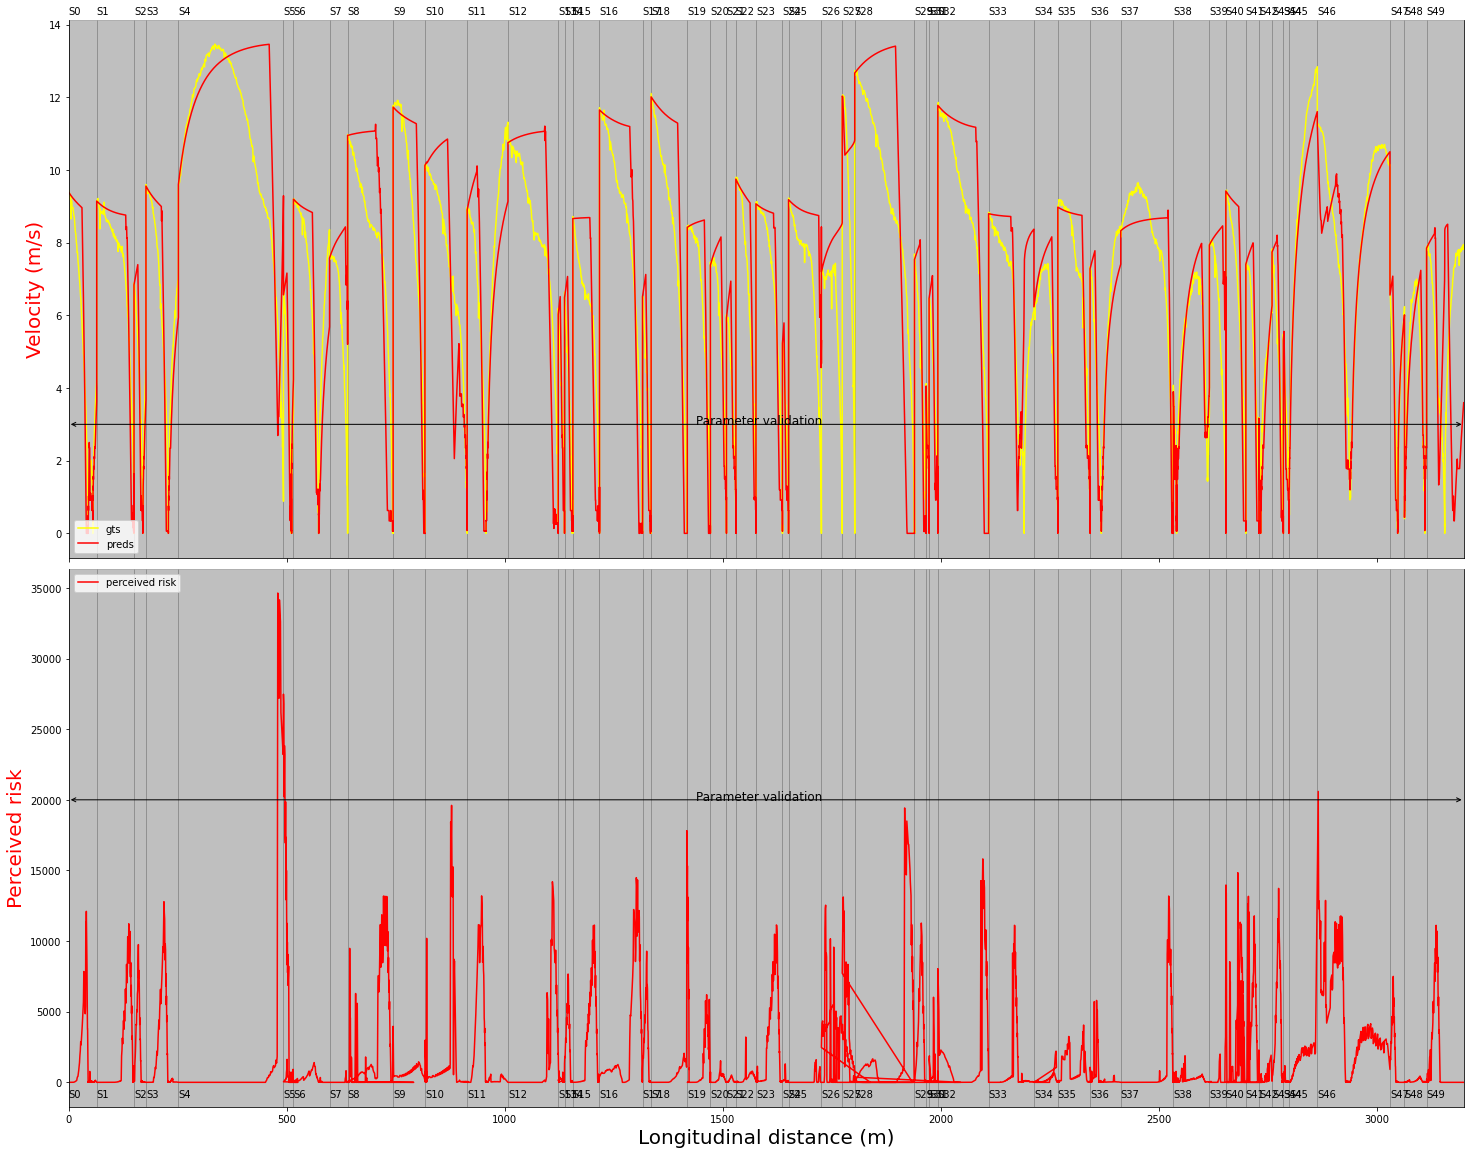

In [22]:
# For plotting validation
from matplotlib.pyplot import text
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
arr3 = np.array(position_gts_world)
arr4 = np.array(position_preds_world)
p_risks = np.array(p_risks)
#print(mean_error_vel)
start = 0 # start index of each scene
long_dis_prev = 0 # longitudinal distance until end of previous scene's ground truth trajectory
long_dis_prev_ = 0 # longitudinal distance until end of previous scene's predicted trajectory
longi_dis = []
longi_dis_ = []
scene_sizes = np.array(scene_sizes)

for scene_size in scene_sizes:
    scene_vels_gt = arr1[start : scene_size]
    scene_vels_preds = arr2[start : scene_size]

    #longitudinal distance
    scene_long_dis = np.sqrt((arr3[start : start + scene_size, 0] - arr3[start, 0])**2 + (arr3[start : start + scene_size, 1] - arr3[start, 1])**2)
    scene_long_dis = scene_long_dis + long_dis_prev
    scene_long_dis_ = np.sqrt((arr4[start : start + scene_size, 0] - arr4[start, 0])**2 + (arr4[start : start + scene_size, 1] - arr4[start, 1])**2)
    scene_long_dis_ = scene_long_dis_ + long_dis_prev

    start += scene_size 
    long_dis_prev = scene_long_dis[-1]

    long_dis_prev_ = scene_long_dis_[-1]
    longi_dis.append(scene_long_dis)
    longi_dis_.append(scene_long_dis_)

longi_dis = np.array(longi_dis)
longi_dis = np.hstack(longi_dis)
# longi_dis = smooth(longi_dis, 10)

longi_dis_ = np.array(longi_dis_)
longi_dis_ = np.hstack(longi_dis_)
time = np.arange(0, longi_dis.size / 10.0, 0.1)
# longi_dis_ = smooth(longi_dis_, 10)

# vel_preds = smooth(vel_preds, 10)
# vel_gts = smooth(vel_gts, 10)
vel_error_arr, mean_error_vel = computeVelError(vel_preds, vel_gts)
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)

# create figure and axis objects with subplots()
fig, (ax,ax_) = plt.subplots(2, sharex=True, figsize=(25, 20))
ax.spines['top'].set_visible(False)

# make a plot
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    ax.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
    if (scene_idx == scene_sizes.size - 1):
        val_end = longi_dis[vline_prev + scene_size - 1]
        ax.annotate('', xy=(iden_end, 3), xycoords='data', xytext=(val_end, 3), textcoords='data', arrowprops={'arrowstyle': '<->'})
        ax.text((iden_end + val_end) * 0.45, 3, 'Parameter validation', fontsize=12)
    ax.text(longi_dis[vline_prev], 14.5, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += scene_size
    scene_idx += 1
    
ax.plot(longi_dis, arr1, markersize=4, label = "gts", color="yellow")
#ax.plot(longi_dis[4:-4], smooth(arr1,9), label = "gts", color="red")
ax.plot(longi_dis, arr2, markersize=2, label = "preds", color="red")
# set x-axis label
#ax.set_xlabel("Longitudinal distance (m)",fontsize=20)
# set y-axis label
ax.set_ylabel("Velocity (m/s)",color="red",fontsize=20)
ax.legend()

# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.spines['top'].set_visible(False)
# ax2.plot(longi_dis_, p_risks, label = "perceived risk", color="blue")
# ax2.set_ylabel("perceived risk",color="blue",fontsize=20)

# # mean and std of velocity error
# std = np.std(error_arr)
# ax2.axhline(mean_error_vel, color='k', linestyle='dashed', label='mean velocity error')
# ax2.axhline(mean_error_vel + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean_error_vel - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() #+ ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='lower left')
axes = plt.gca()
axes.set_xlim([0, val_end])
# axes.set_ylim([-2200, -2170])
# plt.legend()
#plt.show()


# plot figure 2
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    ax_.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
    if (scene_idx == scene_sizes.size - 1):
        val_end = longi_dis[vline_prev + scene_size - 1]
        ax_.annotate('', xy=(iden_end, 20000), xycoords='data', xytext=(val_end, 20000), textcoords='data', arrowprops={'arrowstyle': '<->'})
        ax_.text((iden_end + val_end) * 0.45, 20000, 'Parameter validation', fontsize=12)
    ax_.text(longi_dis[vline_prev], -500, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += (scene_size)
    scene_idx += 1
    
# ax_.plot(longi_dis, time, markersize=2, label = "gts", color="red")
# ax_.plot(longi_dis_, time, markersize=8, label = "preds", color="yellow")    
ax_.plot(longi_dis_, p_risks, label = "perceived risk", color="red")
ax_.set_ylabel("Perceived risk",color="red",fontsize=20)
# set x-axis label    
ax_.set_xlabel("Longitudinal distance (m)",fontsize=20)    
ax_.set_ylabel("Perceived risk",color="red",fontsize=20)    
ax_.spines['top'].set_visible(False)
ax_.legend()

# twin object for two different y-axis on the sample plot
# ax_2=ax_.twinx()
# ax_2.spines['top'].set_visible(False)

# make a plot with different y-axis using second axis object
#ax_2.plot(longi_dis, error_arr, markersize=2, label = "position error", color="blue")
#ax_2.set_ylabel("Position error (m)",color="blue",fontsize=20)
# ax_2.plot(longi_dis_, p_risks, label = "perceived risk", color="blue")
# ax_2.set_ylabel("perceived risk",color="blue",fontsize=20)

lines = ax_.get_lines() #+ ax_2.get_lines()
ax_.legend(lines, [line.get_label() for line in lines], loc='upper left')

axes_ = plt.gca()
axes_.set_xlim([0, val_end])
# axes_.set_ylim([-1, 16])
# plt.legend()
plt.subplots_adjust(hspace=0.02)
plt.show()

# save the plot as a file
fig.savefig('iden_val_vel_pos.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/2520293701.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis = np.array(longi_dis)
C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/2520293701.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis_ = np.array(longi_dis_)


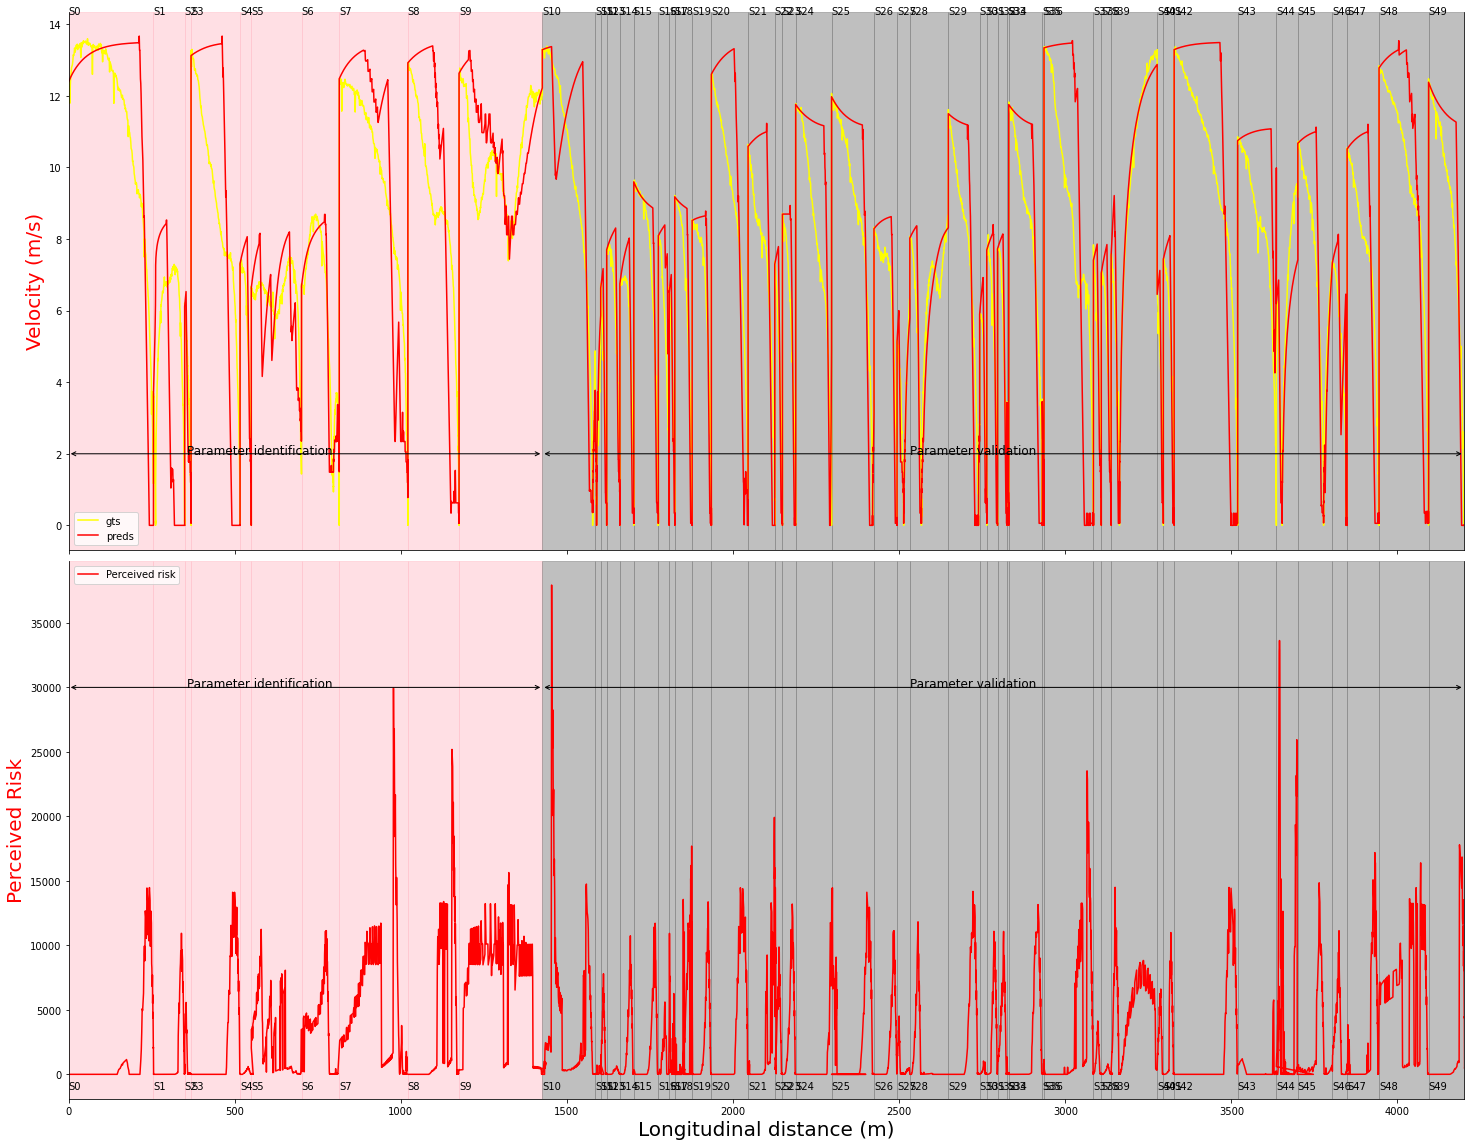

In [20]:
from matplotlib.pyplot import text
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
arr3 = np.array(position_gts_world)
arr4 = np.array(position_preds_world)
p_risks = np.array(p_risks)
#print(mean_error_vel)
start = 0 # start index of each scene
long_dis_prev = 0 # longitudinal distance until end of previous scene's ground truth trajectory
long_dis_prev_ = 0 # longitudinal distance until end of previous scene's predicted trajectory
longi_dis = []
longi_dis_ = []
scene_sizes = np.array(scene_sizes)

for scene_size in scene_sizes:
    scene_vels_gt = arr1[start : scene_size]
    scene_vels_preds = arr2[start : scene_size]

    #longitudinal distance
    scene_long_dis = np.sqrt((arr3[start : start + scene_size, 0] - arr3[start, 0])**2 + (arr3[start : start + scene_size, 1] - arr3[start, 1])**2)
    scene_long_dis = scene_long_dis + long_dis_prev
    scene_long_dis_ = np.sqrt((arr4[start : start + scene_size, 0] - arr4[start, 0])**2 + (arr4[start : start + scene_size, 1] - arr4[start, 1])**2)
    scene_long_dis_ = scene_long_dis_ + long_dis_prev

    start += scene_size 
    long_dis_prev = scene_long_dis[-1]

    long_dis_prev_ = scene_long_dis_[-1]
    longi_dis.append(scene_long_dis)
    longi_dis_.append(scene_long_dis_)

longi_dis = np.array(longi_dis)
longi_dis = np.hstack(longi_dis)
time = np.arange(0, longi_dis.size / 10.0, 0.1)
# longi_dis = smooth(longi_dis, 10)

longi_dis_ = np.array(longi_dis_)
longi_dis_ = np.hstack(longi_dis_)
# longi_dis_ = smooth(longi_dis_, 10)

# vel_preds = smooth(vel_preds, 10)
# vel_gts = smooth(vel_gts, 10)
vel_error_arr, mean_error_vel = computeVelError(vel_preds, vel_gts)
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)

# create figure and axis objects with subplots()
fig, (ax,ax_) = plt.subplots(2, sharex=True, figsize=(25, 20))
ax.spines['top'].set_visible(False)

# make a plot
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    #ax.vlines(x=longi_dis[vline_prev + scene_size - 1], ymin=0, ymax=15, colors='yellow', linewidth=1)
    if (scene_idx < 10):
        ax.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='pink')
        if (scene_idx == 9):
            iden_end = longi_dis[vline_prev + scene_size - 1]
            ax.annotate('', xy=(0, 2), xycoords='data', xytext=(iden_end, 2), textcoords='data', arrowprops={'arrowstyle': '<->'})
            ax.text(iden_end * 0.25, 2, 'Parameter identification', fontsize=12)
    if (scene_idx >= 10):
        ax.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
        if (scene_idx == scene_sizes.size - 1):
            val_end = longi_dis[vline_prev + scene_size - 1]
            ax.annotate('', xy=(iden_end, 2), xycoords='data', xytext=(val_end, 2), textcoords='data', arrowprops={'arrowstyle': '<->'})
            ax.text((iden_end + val_end) * 0.45, 2, 'Parameter validation', fontsize=12)
    ax.text(longi_dis[vline_prev], 14.5, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += scene_size
    scene_idx += 1
    
ax.plot(longi_dis, arr1, markersize=4, label = "gts", color="yellow")
#ax.plot(longi_dis[4:-4], smooth(arr1,9), label = "gts", color="red")
ax.plot(longi_dis, arr2, markersize=2, label = "preds", color="red")
# set x-axis label
#ax.set_xlabel("Longitudinal distance (m)",fontsize=20)
# set y-axis label
ax.set_ylabel("Velocity (m/s)",color="red",fontsize=20)
ax.legend()

# twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# # make a plot with different y-axis using second axis object
# ax2.spines['top'].set_visible(False)
# ax2.plot(longi_dis_, p_risks, label = "perceived risk", color="blue")
# ax2.set_ylabel("perceived risk",color="blue",fontsize=20)

# # mean and std of velocity error
# std = np.std(error_arr)
# ax2.axhline(mean_error_vel, color='k', linestyle='dashed', label='mean velocity error')
# ax2.axhline(mean_error_vel + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean_error_vel - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() #+ ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='lower left')
axes = plt.gca()
axes.set_xlim([0, val_end])
# axes.set_ylim([-2200, -2170])
# plt.legend()
#plt.show()


# plot figure 2
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    if (scene_idx < 10):
        ax_.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='pink')
        if (scene_idx == 9):
            iden_end = longi_dis[vline_prev + scene_size - 1]
            ax_.annotate('', xy=(0, 30000), xycoords='data', xytext=(iden_end, 30000), textcoords='data', arrowprops={'arrowstyle': '<->'})
            ax_.text(iden_end * 0.25, 30000, 'Parameter identification', fontsize=12)
    if (scene_idx >= 10):
        ax_.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
        if (scene_idx == scene_sizes.size - 1):
            val_end = longi_dis[vline_prev + scene_size - 1]
            ax_.annotate('', xy=(iden_end, 30000), xycoords='data', xytext=(val_end, 30000), textcoords='data', arrowprops={'arrowstyle': '<->'})
            ax_.text((iden_end + val_end) * 0.45, 30000, 'Parameter validation', fontsize=12)
    ax_.text(longi_dis[vline_prev], -500, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += (scene_size)
    scene_idx += 1
    
# ax_.plot(longi_dis, time, markersize=2, label = "gts", color="red")
# ax_.plot(longi_dis_, time, markersize=8, label = "preds", color="yellow")    
ax_.plot(longi_dis_, p_risks, label = "Perceived risk", color="red")
ax_.set_ylabel("Perceived risk",color="red",fontsize=20)
# set x-axis label    
ax_.set_xlabel("Longitudinal distance (m)",fontsize=20)    
ax_.set_ylabel("Perceived Risk",color="red",fontsize=20)    
ax_.spines['top'].set_visible(False)
ax_.legend()

# twin object for two different y-axis on the sample plot
# ax_2=ax_.twinx()
# ax_2.spines['top'].set_visible(False)

# make a plot with different y-axis using second axis object
#ax_2.plot(longi_dis, error_arr, markersize=2, label = "position error", color="blue")
#ax_2.set_ylabel("Position error (m)",color="blue",fontsize=20)
# ax_2.plot(longi_dis_, p_risks, label = "perceived risk", color="blue")
# ax_2.set_ylabel("perceived risk",color="blue",fontsize=20)

lines = ax_.get_lines() #+ ax_2.get_lines()
ax_.legend(lines, [line.get_label() for line in lines], loc='upper left')

axes_ = plt.gca()
axes_.set_xlim([0, val_end])
#axes_.set_ylim([-1, 15])
# plt.legend()
plt.subplots_adjust(hspace=0.02)
plt.show()

# save the plot as a file
fig.savefig('iden_val_vel_pos.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/3322061882.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis = np.array(longi_dis)
C:\Users\q8xeup\AppData\Local\Temp/ipykernel_9184/3322061882.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  longi_dis_ = np.array(longi_dis_)


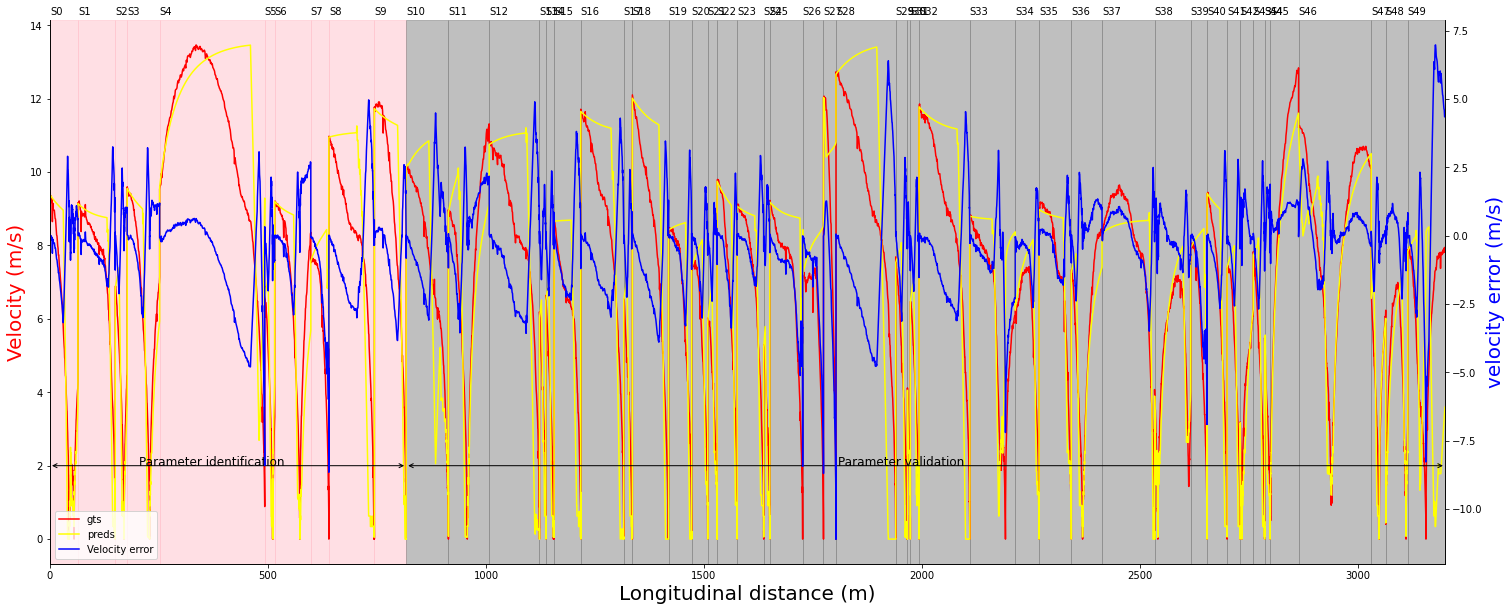

In [23]:
from matplotlib.pyplot import text
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
arr3 = np.array(position_gts_world)
arr4 = np.array(position_preds_world)
#print(mean_error_vel)
start = 0 # start index of each scene
long_dis_prev = 0 # longitudinal distance until end of previous scene's ground truth trajectory
long_dis_prev_ = 0 # longitudinal distance until end of previous scene's predicted trajectory
longi_dis = []
longi_dis_ = []
scene_sizes = np.array(scene_sizes)

for scene_size in scene_sizes:
    scene_vels_gt = arr1[start : scene_size]
    scene_vels_preds = arr2[start : scene_size]

    #longitudinal distance
    scene_long_dis = np.sqrt((arr3[start : start + scene_size, 0] - arr3[start, 0])**2 + (arr3[start : start + scene_size, 1] - arr3[start, 1])**2)
    scene_long_dis = scene_long_dis + long_dis_prev
    scene_long_dis_ = np.sqrt((arr4[start : start + scene_size, 0] - arr4[start, 0])**2 + (arr4[start : start + scene_size, 1] - arr4[start, 1])**2)
    scene_long_dis_ = scene_long_dis_ + long_dis_prev_

    start += scene_size 
    long_dis_prev = scene_long_dis[-1]

    long_dis_prev_ = scene_long_dis_[-1]
    longi_dis.append(scene_long_dis)
    longi_dis_.append(scene_long_dis_)

longi_dis = np.array(longi_dis)
longi_dis = np.hstack(longi_dis)
# longi_dis = smooth(longi_dis, 10)

longi_dis_ = np.array(longi_dis_)
longi_dis_ = np.hstack(longi_dis_)
# longi_dis_ = smooth(longi_dis_, 10)

# vel_preds = smooth(vel_preds, 10)
# vel_gts = smooth(vel_gts, 10)
vel_error_arr, mean_error_vel = computeVelError(vel_preds, vel_gts)

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(25, 10))
ax.spines['top'].set_visible(False)

# make a plot
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    #ax.vlines(x=longi_dis[vline_prev + scene_size - 1], ymin=0, ymax=15, colors='yellow', linewidth=1)
    if (scene_idx < 10):
        ax.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='pink')
        if (scene_idx == 9):
            iden_end = longi_dis[vline_prev + scene_size - 1]
            plt.annotate('', xy=(0, 2), xycoords='data', xytext=(iden_end, 2), textcoords='data', arrowprops={'arrowstyle': '<->'})
            plt.text(iden_end * 0.25, 2, 'Parameter identification', fontsize=12)
    if (scene_idx >= 10):
        ax.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
        if (scene_idx == scene_sizes.size - 1):
            val_end = longi_dis[vline_prev + scene_size - 1]
            plt.annotate('', xy=(iden_end, 2), xycoords='data', xytext=(val_end, 2), textcoords='data', arrowprops={'arrowstyle': '<->'})
            plt.text((iden_end + val_end) * 0.45, 2, 'Parameter validation', fontsize=12)
    text(longi_dis[vline_prev], 14.5, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += scene_size
    scene_idx += 1
    
ax.plot(longi_dis, arr1, markersize=4, label = "gts", color="red")
#ax.plot(longi_dis[4:-4], smooth(arr1,9), label = "gts", color="red")
ax.plot(longi_dis, arr2, markersize=2, label = "preds", color="yellow")
# set x-axis label
ax.set_xlabel("Longitudinal distance (m)",fontsize=20)
# set y-axis label
ax.set_ylabel("Velocity (m/s)",color="red",fontsize=20)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.spines['top'].set_visible(False)
ax2.plot(longi_dis, vel_error_arr, label = "Velocity error", color="blue")
ax2.set_ylabel("velocity error (m/s)",color="blue",fontsize=20)

# # mean and std of velocity error
# std = np.std(error_arr)
# ax2.axhline(mean_error_vel, color='k', linestyle='dashed', label='mean velocity error')
# ax2.axhline(mean_error_vel + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean_error_vel - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='lower left')
axes = plt.gca()
axes.set_xlim([0, val_end])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('iden_val_vel.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')


2.364363783636372


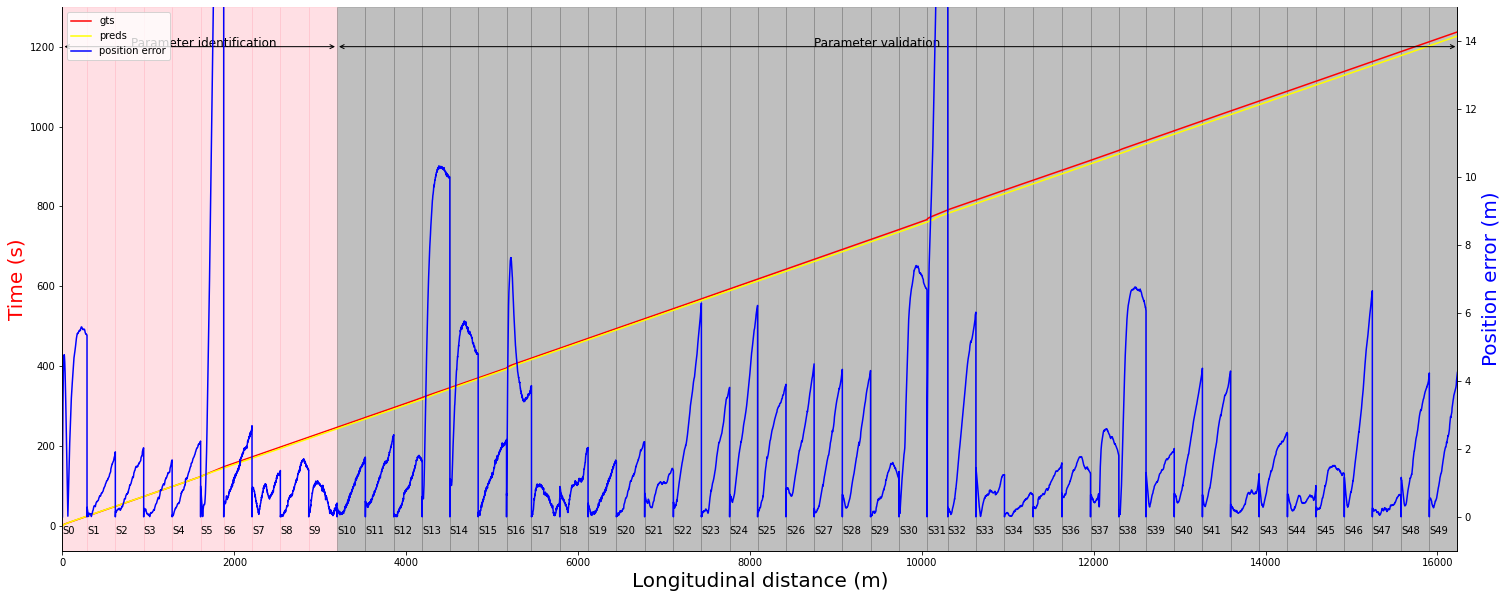

In [40]:
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)
print(mean_error_pos)

time = np.arange(0, longi_dis.size / 10.0, 0.1) # time step is 0.1s

# create figure and axis objects with subplots()
fig_,ax_ = plt.subplots(figsize=(25, 10))

# plot figures
vline_prev = 0
scene_idx = 0
iden_end = 0
val_end = 0
for scene_size in scene_sizes:
    if (scene_idx < 10):
        ax_.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='pink')
        if (scene_idx == 9):
            iden_end = longi_dis[vline_prev + scene_size - 1]
            plt.annotate('', xy=(0, 1200), xycoords='data', xytext=(iden_end, 1200), textcoords='data', arrowprops={'arrowstyle': '<->'})
            plt.text(iden_end * 0.25, 1200, 'Parameter identification', fontsize=12)
    if (scene_idx >= 10):
        ax_.axvspan(longi_dis[vline_prev], longi_dis[vline_prev + scene_size - 1], alpha=0.5, color='grey')
        if (scene_idx == scene_sizes.size - 1):
            val_end = longi_dis[vline_prev + scene_size - 1]
            plt.annotate('', xy=(iden_end, 1200), xycoords='data', xytext=(val_end, 1200), textcoords='data', arrowprops={'arrowstyle': '<->'})
            plt.text((iden_end + val_end) * 0.45, 1200, 'Parameter validation', fontsize=12)
    text(longi_dis[vline_prev], -0.5, "S%d" % scene_idx, rotation=0, verticalalignment='top')
    vline_prev += (scene_size)
    scene_idx += 1
    
ax_.plot(longi_dis, time, markersize=2, label = "gts", color="red")
ax_.plot(longi_dis_, time, markersize=8, label = "preds", color="yellow")    
# set x-axis label    
ax_.set_xlabel("Longitudinal distance (m)",fontsize=20)    
ax_.set_ylabel("Time (s)",color="red",fontsize=20)    
ax_.spines['top'].set_visible(False)
ax_.legend()

# twin object for two different y-axis on the sample plot
ax_2=ax_.twinx()
ax_2.spines['top'].set_visible(False)

# make a plot with different y-axis using second axis object
ax_2.plot(longi_dis, error_arr, markersize=2, label = "position error", color="blue")
ax_2.set_ylabel("Position error (m)",color="blue",fontsize=20)

lines = ax_.get_lines() + ax_2.get_lines()
ax_.legend(lines, [line.get_label() for line in lines], loc='upper left')

axes_ = plt.gca()
axes_.set_xlim([0, val_end])
axes_.set_ylim([-1, 15])

ax.get_shared_x_axes().join(ax, ax_)
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('iden_val_pos.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')